In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
infrared_thermography_temperature = fetch_ucirepo(id=925) 

X = infrared_thermography_temperature.data.features 
y = infrared_thermography_temperature.data.targets
df1 = pd.concat([X, y], axis=1)
df = df1.drop('aveOralM', axis=1)

In [ ]:
df.to_csv('ucidata.csv')

In [3]:
# Partition the data into a training set (80%) and a testing set (20%)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 816, Test size: 204


In [4]:
target_col = 'aveOralF'

# Define feature groups
env_features = ['T_atm', 'Humidity', 'Distance', 'T_offset1']
continuous_cols = train_df.select_dtypes(include=[float, int]).columns.tolist()
tskin_features = [col for col in continuous_cols if col != target_col and col not in env_features]
# Correlation matrix
corr_matrix = train_df[tskin_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Features to drop if correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Final list
tskin_features_filtered = [col for col in tskin_features if col not in to_drop]

reduced_cols = tskin_features_filtered + env_features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaled = train_df.copy()
test_scaled = test_df.copy()

# Combine Tskin and environmental variables (no log-transform used)
reduced_cols = tskin_features_filtered + env_features

# Standardize
train_scaled[reduced_cols] = scaler.fit_transform(train_df[reduced_cols])
test_scaled[reduced_cols] = scaler.transform(test_df[reduced_cols])



## OLS 
different part of face values, environment variavles

In [7]:
train1_df, val_df = train_test_split(train_scaled, test_size=0.2, random_state=33)
print(f"Train size: {len(train1_df)}, Val size: {len(val_df)}")

Train size: 652, Val size: 164


In [8]:
column_means = train1_df.mean(numeric_only=True) 
train1_df = train1_df.fillna(column_means)
train1_df['Distance'] = train1_df['Distance'].fillna(0.62)
X_train = train1_df[reduced_cols]
y_train = train1_df[target_col]


X_train = sm.add_constant(X_train)


model = sm.OLS(y_train, X_train)
ols1_results = model.fit()

print(ols1_results.summary())

                            OLS Regression Results                            
Dep. Variable:               aveOralF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     68.17
Date:                Tue, 13 May 2025   Prob (F-statistic):          3.97e-126
Time:                        14:01:09   Log-Likelihood:                -11.835
No. Observations:                 652   AIC:                             57.67
Df Residuals:                     635   BIC:                             133.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.9803      0.010   3772.742      

We can see that there is significantly negative relationship between T_atm and target.

Other significant indicators are T_Max1, aveAllL13_1, T_FHRC1, T_FH_Max1, T_OR_Max1, T_FHBC1.

In [9]:
column_means = train_scaled.mean(numeric_only=True) 
train_scaled = train_scaled.fillna(column_means)
train_scaled['Distance'] = train_scaled['Distance'].fillna(0.62)
X_train = train_scaled[reduced_cols]
y_train = train_scaled[target_col]


X_train = sm.add_constant(X_train)


model = sm.OLS(y_train, X_train)
ols_results = model.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:               aveOralF   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     80.18
Date:                Tue, 13 May 2025   Prob (F-statistic):          8.25e-154
Time:                        14:01:20   Log-Likelihood:                -9.9778
No. Observations:                 816   AIC:                             53.96
Df Residuals:                     799   BIC:                             133.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.9817      0.009   4267.630      

In [10]:
val_df = val_df.fillna(column_means)
val_df['Distance'] = val_df['Distance'].fillna(0.62)
X_val = val_df[reduced_cols]
y_val = val_df[target_col]

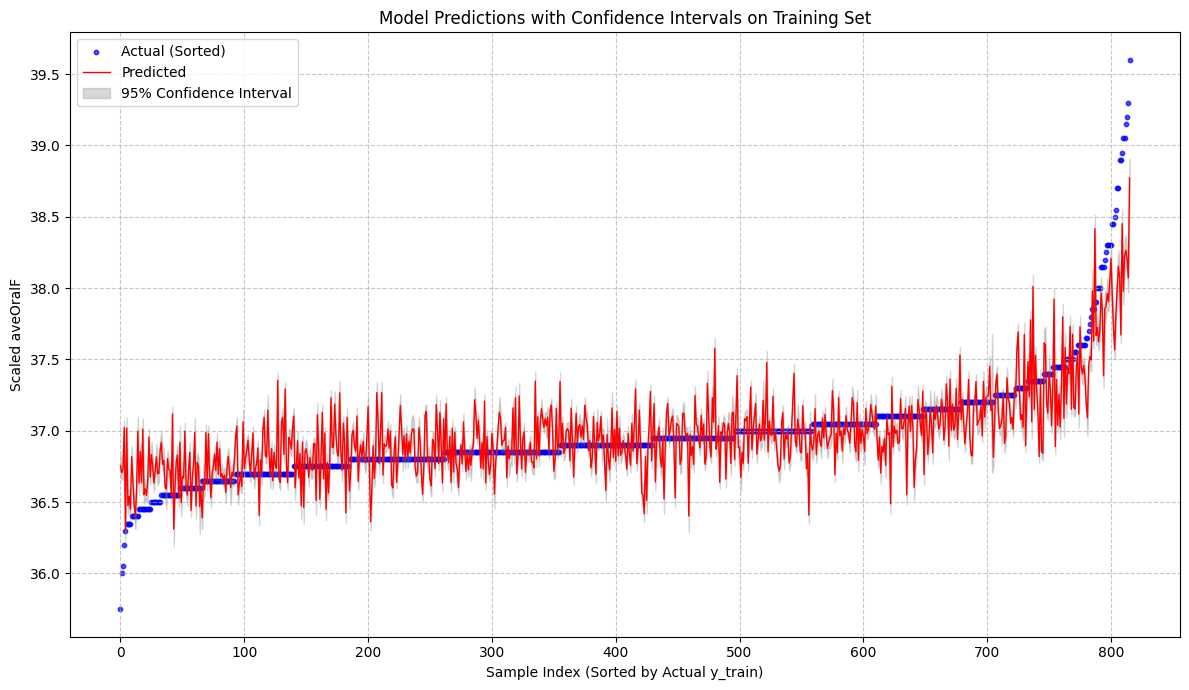

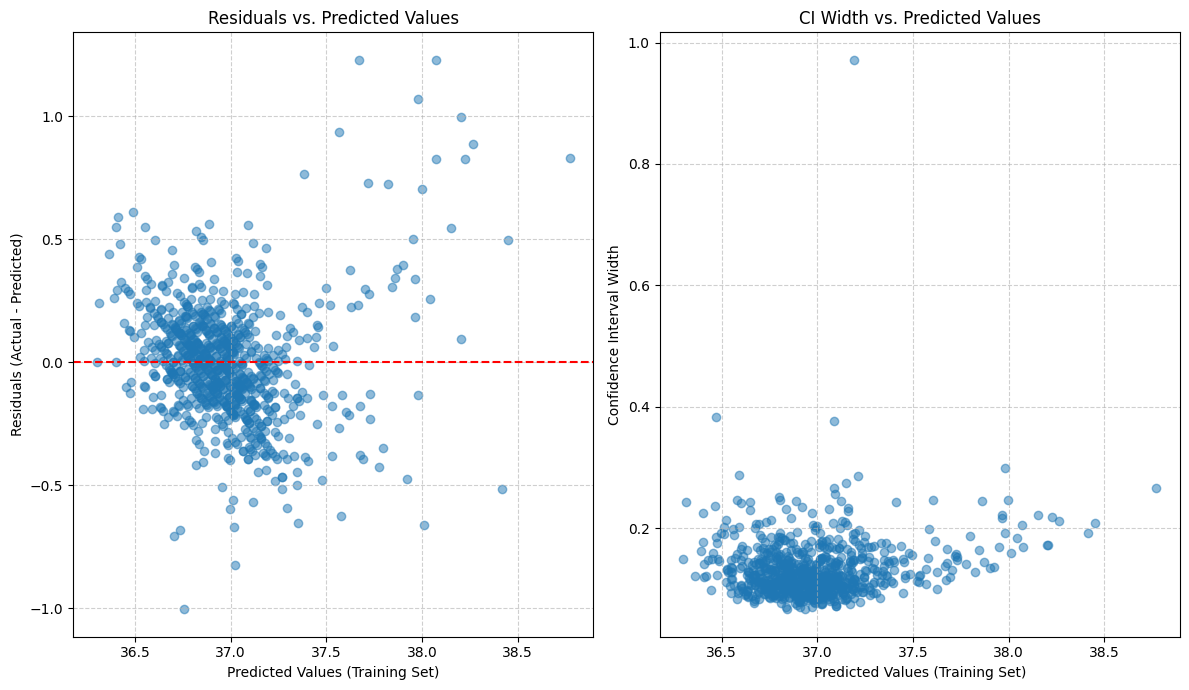

In [11]:
pred_results_train = ols_results.get_prediction(X_train)

y_pred_train = pred_results_train.predicted_mean

conf_int_train = pred_results_train.conf_int(alpha=0.05)
lower_bound_train = conf_int_train[:, 0]
upper_bound_train = conf_int_train[:, 1]

sort_indices = np.argsort(y_train.values)

y_train_sorted = y_train.values[sort_indices]
y_pred_train_sorted = y_pred_train[sort_indices]
lower_bound_train_sorted = lower_bound_train[sort_indices]
upper_bound_train_sorted = upper_bound_train[sort_indices]

plt.figure(figsize=(12, 7))

plt.scatter(range(len(y_train_sorted)), y_train_sorted, color='blue', label='Actual (Sorted)', s=10, alpha=0.7)

plt.plot(range(len(y_pred_train_sorted)), y_pred_train_sorted, color='red', linestyle='-', linewidth=1, label='Predicted')

plt.fill_between(range(len(y_pred_train_sorted)),
                 lower_bound_train_sorted,
                 upper_bound_train_sorted,
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Sample Index (Sorted by Actual y_train)")
plt.ylabel(f"Scaled {target_col}")
plt.title("Model Predictions with Confidence Intervals on Training Set")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

residuals_train = y_train - y_pred_train
ci_width_train = upper_bound_train - lower_bound_train

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Training Set)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_train, ci_width_train, alpha=0.5)
plt.xlabel("Predicted Values (Training Set)")
plt.ylabel("Confidence Interval Width")
plt.title("CI Width vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE: 0.0586
R-squared: 0.5136




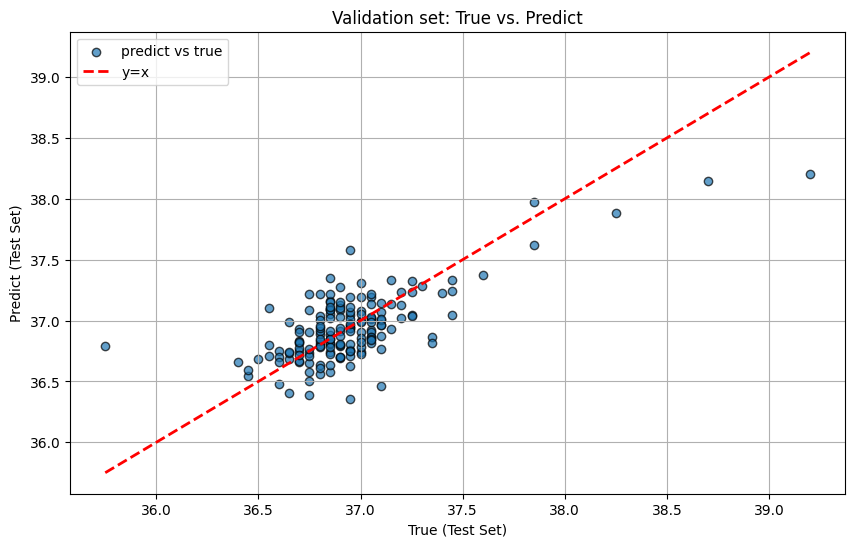

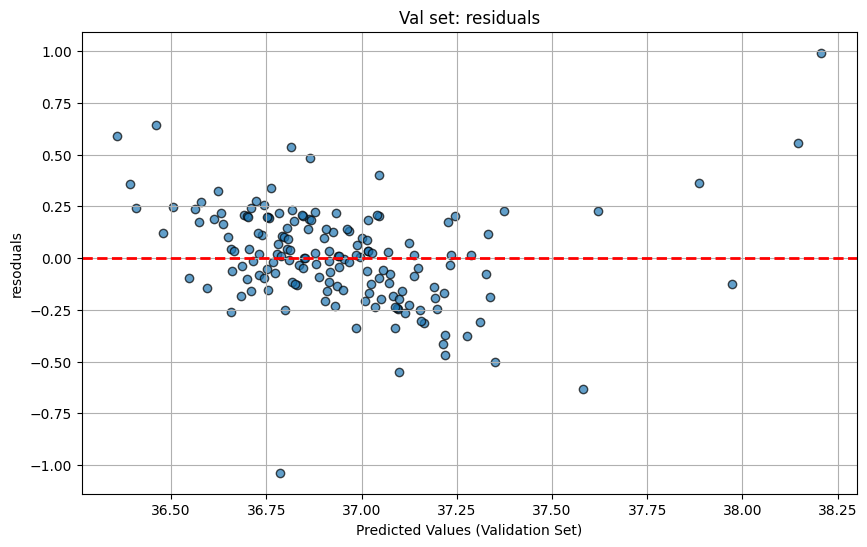

In [13]:
X_test_const = sm.add_constant(X_val, has_constant='add')

y_pred_test = ols1_results.predict(X_test_const)

mse_test = mean_squared_error(y_val, y_pred_test)
r2_test = r2_score(y_val, y_pred_test)

print(f"MSE: {mse_test:.4f}")
print(f"R-squared: {r2_test:.4f}")
print("\n")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_test, alpha=0.7, edgecolors='k', label='predict vs true')

min_val = min(y_val.min(), y_pred_test.min())
max_val = max(y_val.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
plt.xlabel("True (Test Set)")
plt.ylabel("Predict (Test Set)")
plt.title("Validation set: True vs. Predict")
plt.legend()
plt.grid(True)
plt.show()

residuals_test = y_val - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Values (Validation Set)")
plt.ylabel("resoduals")
plt.title("Val set: residuals")
plt.grid(True)
plt.show()

In [14]:
test_scaled = test_scaled.fillna(column_means)
X_test = test_scaled[reduced_cols]
y_test = test_scaled[target_col]

## WLS - also for correlation interpretation/deal with imbalanced data

In [15]:
from scipy.stats import gaussian_kde

weights shape: (652,)
weights: min=0.6238, max=177.0449, mean=3.4510


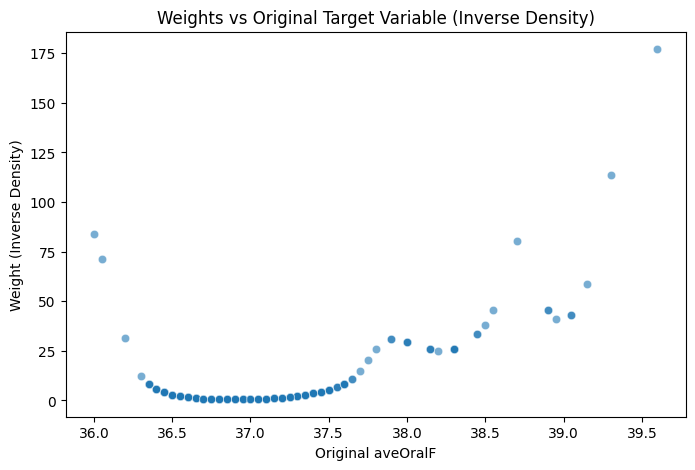

                            WLS Regression Results                            
Dep. Variable:               aveOralF   R-squared:                       0.899
Model:                            WLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     352.1
Date:                Tue, 13 May 2025   Prob (F-statistic):          6.58e-303
Time:                        14:01:44   Log-Likelihood:                -572.97
No. Observations:                 652   AIC:                             1180.
Df Residuals:                     635   BIC:                             1256.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.9912      0.020   1893.897      

In [16]:
column_means = train1_df.mean(numeric_only=True) 
train1_df = train1_df.fillna(column_means)
train1_df['Distance'] = train1_df['Distance'].fillna(0.62)
X_train = train1_df[reduced_cols]
y_train = train1_df[target_col]
target_column_name = target_col

X_train = sm.add_constant(X_train)



y_original = train1_df[target_column_name]
kde = gaussian_kde(y_original)
density_values = kde(y_original)

epsilon = 1e-6
weights_method_B = 1 / (density_values + epsilon)

print(f"weights shape: {weights_method_B.shape}")
print(f"weights: min={weights_method_B.min():.4f}, max={weights_method_B.max():.4f}, mean={weights_method_B.mean():.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_original, y=weights_method_B, alpha=0.6)
plt.xlabel(f"Original {target_column_name}")
plt.ylabel("Weight (Inverse Density)")
plt.title("Weights vs Original Target Variable (Inverse Density)")
plt.show()

# weights_method_B = weights_method_B / weights_method_B.mean()


weights_to_use1 = weights_method_B


# fit WLS
wls_model = sm.WLS(y_train, X_train, weights=weights_to_use1)
wls_results = wls_model.fit()

print(wls_results.summary())

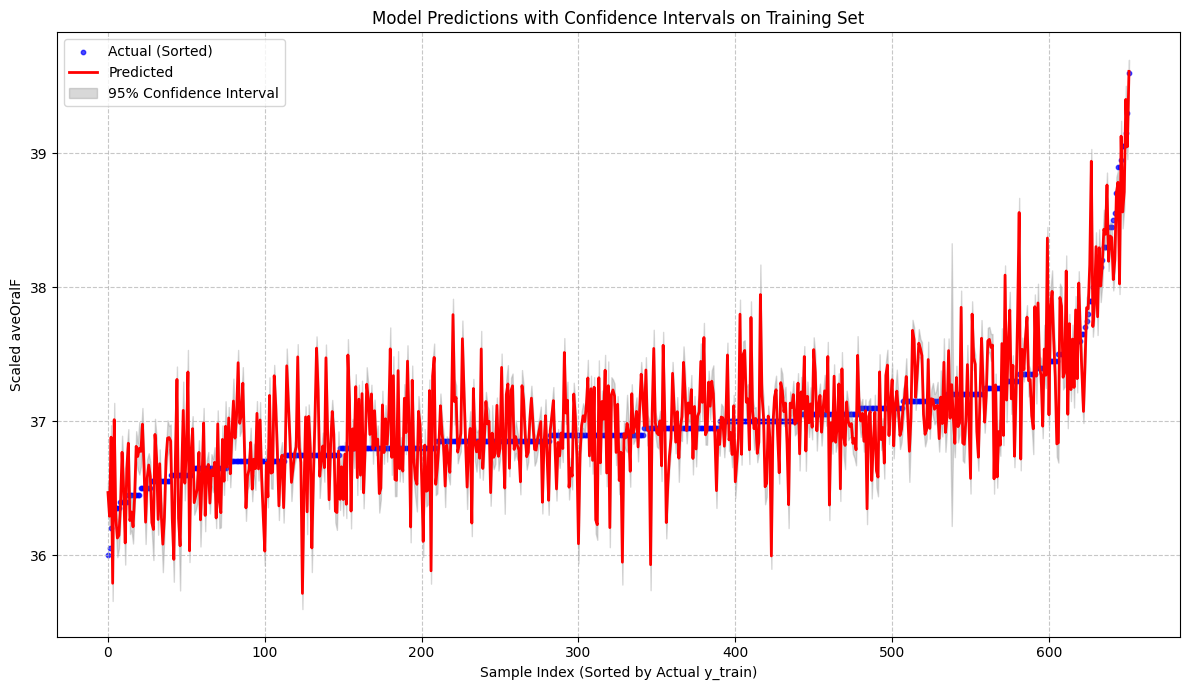

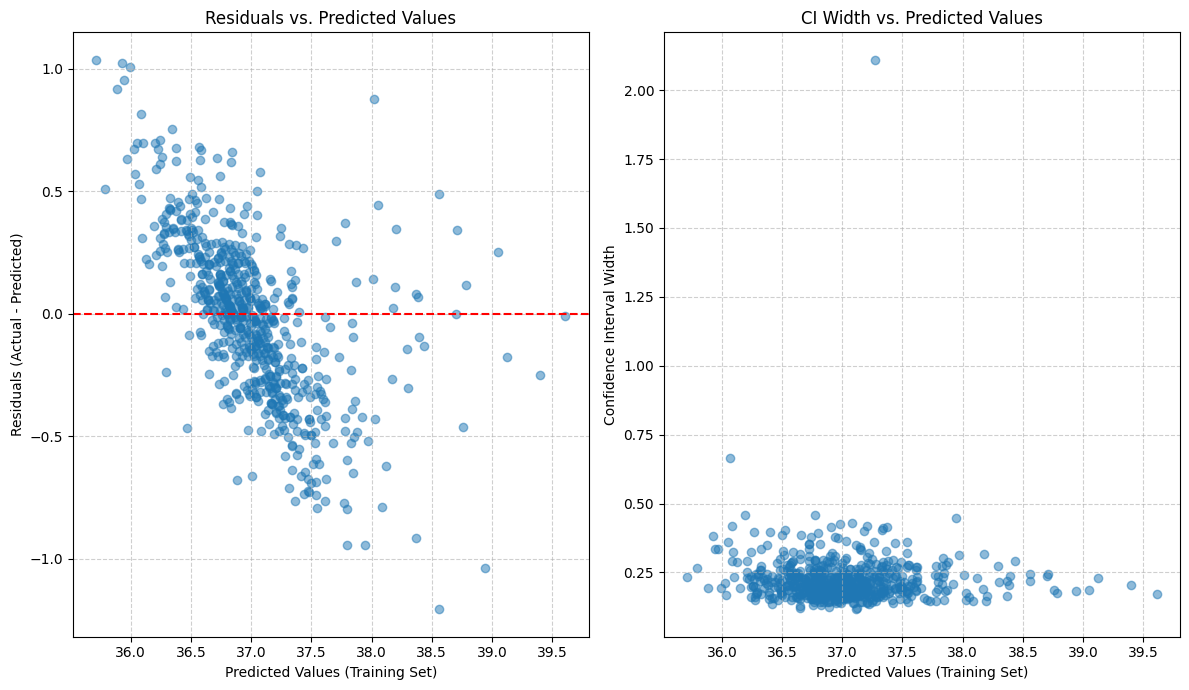

In [17]:
pred_results_train = wls_results.get_prediction(X_train)

y_pred_train = pred_results_train.predicted_mean

conf_int_train = pred_results_train.conf_int(alpha=0.05)
lower_bound_train = conf_int_train[:, 0]
upper_bound_train = conf_int_train[:, 1]


sort_indices = np.argsort(y_train.values)

y_train_sorted = y_train.values[sort_indices]
y_pred_train_sorted = y_pred_train[sort_indices]
lower_bound_train_sorted = lower_bound_train[sort_indices]
upper_bound_train_sorted = upper_bound_train[sort_indices]

plt.figure(figsize=(12, 7))

plt.scatter(range(len(y_train_sorted)), y_train_sorted, color='blue', label='Actual (Sorted)', s=10, alpha=0.7)

plt.plot(range(len(y_pred_train_sorted)), y_pred_train_sorted, color='red', linestyle='-', linewidth=2, label='Predicted')

plt.fill_between(range(len(y_pred_train_sorted)),
                 lower_bound_train_sorted,
                 upper_bound_train_sorted,
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Sample Index (Sorted by Actual y_train)")
plt.ylabel(f"Scaled {target_col}")
plt.title("Model Predictions with Confidence Intervals on Training Set")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


residuals_train = y_train - y_pred_train
ci_width_train = upper_bound_train - lower_bound_train

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Training Set)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_train, ci_width_train, alpha=0.5)
plt.xlabel("Predicted Values (Training Set)")
plt.ylabel("Confidence Interval Width")
plt.title("CI Width vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

MSE: 0.1243
R-squared: -0.0315




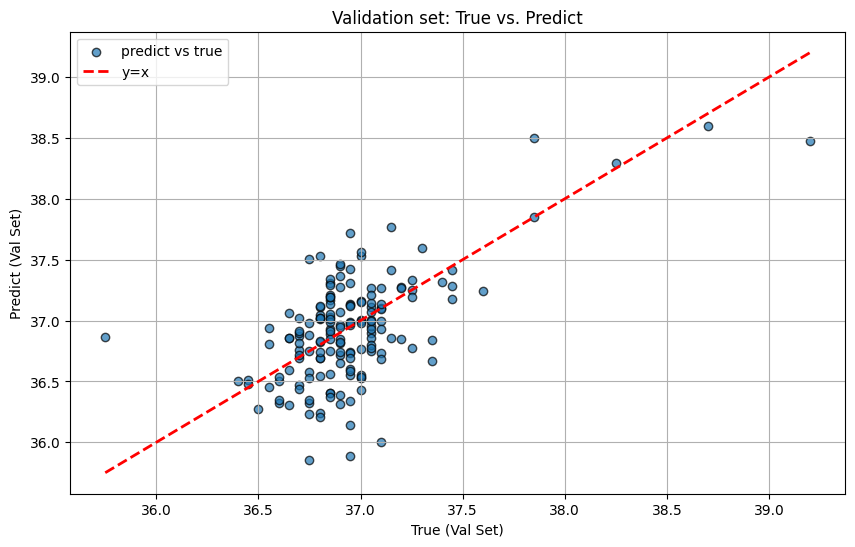

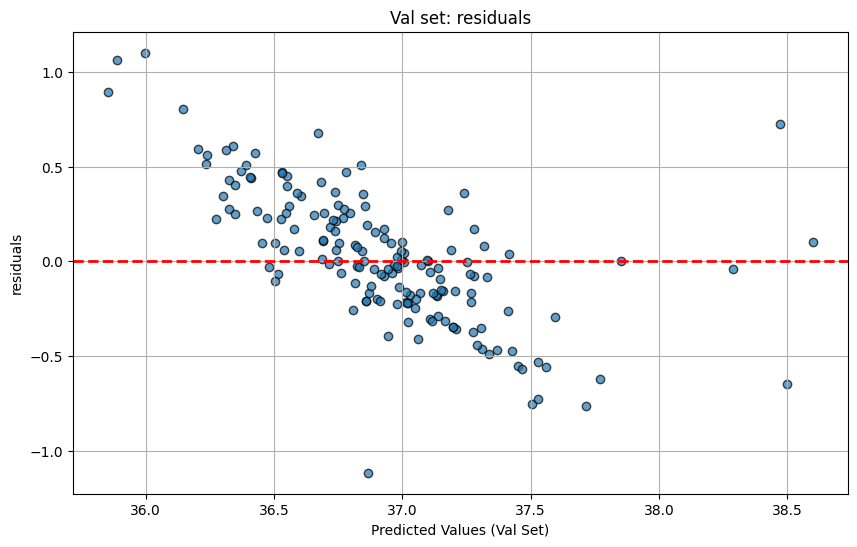

In [18]:
X_test_const = sm.add_constant(X_val, has_constant='add')

y_pred_test = wls_results.predict(X_test_const)

mse_test = mean_squared_error(y_val, y_pred_test)
r2_test = r2_score(y_val, y_pred_test)

print(f"MSE: {mse_test:.4f}")
print(f"R-squared: {r2_test:.4f}")
print("\n")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_test, alpha=0.7, edgecolors='k', label='predict vs true')

min_val = min(y_val.min(), y_pred_test.min())
max_val = max(y_val.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
plt.xlabel("True (Val Set)")
plt.ylabel("Predict (Val Set)")
plt.title("Validation set: True vs. Predict")
plt.legend()
plt.grid(True)
plt.show()

residuals_test = y_val - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Values (Val Set)")
plt.ylabel("residuals")
plt.title("Val set: residuals")
plt.grid(True)
plt.show()


weights shape: (816,)
weights: min=0.5961, max=208.4036, mean=3.6951


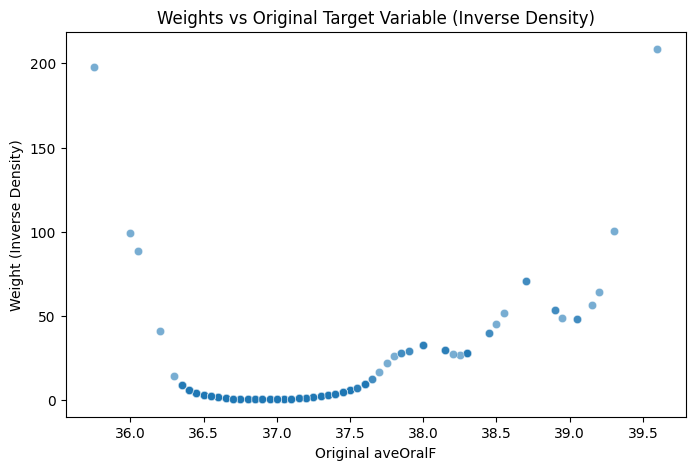

                            WLS Regression Results                            
Dep. Variable:               aveOralF   R-squared:                       0.898
Model:                            WLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     442.0
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        14:01:54   Log-Likelihood:                -813.77
No. Observations:                 816   AIC:                             1662.
Df Residuals:                     799   BIC:                             1742.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.9171      0.018   2012.331      

In [19]:
X_train = train_scaled[reduced_cols]
y_train = train_scaled[target_col]
target_column_name = target_col

X_train = sm.add_constant(X_train)



y_original = train_scaled[target_column_name]
kde = gaussian_kde(y_original)
density_values = kde(y_original)

epsilon = 1e-6
weights_method_B = 1 / (density_values + epsilon)

print(f"weights shape: {weights_method_B.shape}")
print(f"weights: min={weights_method_B.min():.4f}, max={weights_method_B.max():.4f}, mean={weights_method_B.mean():.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_original, y=weights_method_B, alpha=0.6)
plt.xlabel(f"Original {target_column_name}")
plt.ylabel("Weight (Inverse Density)")
plt.title("Weights vs Original Target Variable (Inverse Density)")
plt.show()

# weights_method_B = weights_method_B / weights_method_B.mean()


weights_to_use = weights_method_B


# fit WLS
wls_model = sm.WLS(y_train, X_train, weights=weights_to_use)
wls_results = wls_model.fit()

print(wls_results.summary())

## Lasso -  for better predicting (using cross-validation to reduce overfitting)

In [20]:
from sklearn.linear_model import Lasso, LassoCV 

In [21]:
X_train = train1_df[reduced_cols]
y_train = train1_df[target_col]
# sqrt_weights = np.sqrt(weights_to_use)

# X_weighted = X_train.multiply(sqrt_weights, axis=0)
# y_weighted = y_train * sqrt_weights

lasso_cv_model_weighted = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso_cv_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use1)
best_alpha_weighted = lasso_cv_model_weighted.alpha_
final_lasso_model_weighted = Lasso(alpha=best_alpha_weighted, random_state=42)
final_lasso_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use1)

intercept = final_lasso_model_weighted.intercept_
print(f"Intercept: {intercept:.4f}")

coefficients = final_lasso_model_weighted.coef_
feature_names = X_train.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
non_zero_coefs = coef_df[coef_df['Coefficient'] != 0]
print("\n non-zero coef:")
print(non_zero_coefs.to_string())

print(f"\nLasso chose {len(non_zero_coefs)} features。")
print(f" Number of original features is:{len(feature_names)}。")

Intercept: 36.9908

 non-zero coef:
        Feature  Coefficient
0     Max1R13_1     0.101063
2   aveAllR13_1    -0.022136
3   aveAllL13_1    -0.120298
4       T_FHCC1    -0.032719
5       T_FHRC1    -0.115671
8     T_FH_Max1     0.298504
9    T_FHC_Max1    -0.012664
10       T_Max1     0.116941
11        T_OR1     0.247214
12        T_atm    -0.084393
13     Humidity     0.095840
15    T_offset1     0.101159

Lasso chose 12 features。
 Number of original features is:16。


Mean Squared Error (MSE): 0.1103


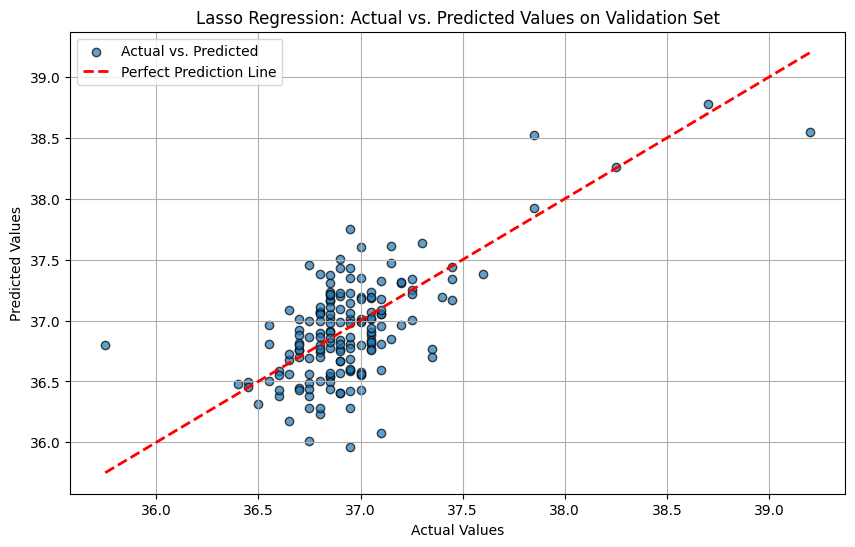

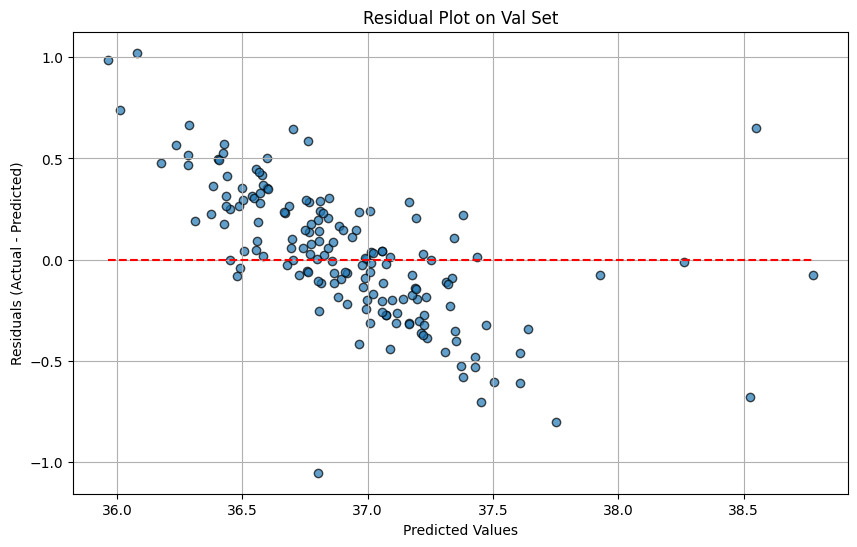

In [22]:
y_pred_test = final_lasso_model_weighted.predict(X_val)

mse_test = mean_squared_error(y_val, y_pred_test)
# r2_test = r2_score(y_val, y_pred_test)

print(f"Mean Squared Error (MSE): {mse_test:.4f}")
# print(f"R-squared (R²): {r2_test:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_test, alpha=0.7, edgecolors='k', label='Actual vs. Predicted')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression: Actual vs. Predicted Values on Validation Set")
plt.legend()
plt.grid(True)
plt.show()

residuals = y_val - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, edgecolors='k')
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot on Val Set")
plt.grid(True)
plt.show()

In [23]:
X_train = train_scaled[reduced_cols]
y_train = train_scaled[target_col]
# sqrt_weights = np.sqrt(weights_to_use)

# X_weighted = X_train.multiply(sqrt_weights, axis=0)
# y_weighted = y_train * sqrt_weights

lasso_cv_model_weighted = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso_cv_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use)
best_alpha_weighted = lasso_cv_model_weighted.alpha_
final_lasso_model_weighted = Lasso(alpha=best_alpha_weighted, random_state=42)
final_lasso_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use)

intercept = final_lasso_model_weighted.intercept_
print(f"Intercept: {intercept:.4f}")

coefficients = final_lasso_model_weighted.coef_
feature_names = X_train.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
non_zero_coefs = coef_df[coef_df['Coefficient'] != 0]
print("\n non-zero coef:")
print(non_zero_coefs.to_string())

print(f"\nLasso chose {len(non_zero_coefs)} features。")
print(f" Number of original features is:{len(feature_names)}。")

Intercept: 36.9070

 non-zero coef:
      Feature  Coefficient
8   T_FH_Max1     0.023182
10     T_Max1     0.368007
11      T_OR1     0.121266
15  T_offset1     0.005663

Lasso chose 4 features。
 Number of original features is:16。


In [24]:
best_alpha_weighted

0.11114003463621944

## Ridge

In [25]:
from sklearn.linear_model import Ridge, RidgeCV

X_train = train1_df[reduced_cols]
y_train = train1_df[target_col]

# alphas_to_try = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_cv_model_weighted = RidgeCV(cv=5)

ridge_cv_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use1)

best_alpha_weighted = ridge_cv_model_weighted.alpha_
# print(f"Best alpha found by RidgeCV: {best_alpha_weighted:.4f}")

final_ridge_model_weighted = Ridge(alpha=best_alpha_weighted, random_state=42)
final_ridge_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use1)

intercept = final_ridge_model_weighted.intercept_
# print(f"Intercept: {intercept:.4f}")

coefficients = final_ridge_model_weighted.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print("\nCoefficients :")
print(coef_df.to_string())



Coefficients :
        Feature  Coefficient
0     Max1R13_1     0.179866
1     Max1L13_1     0.037580
2   aveAllR13_1    -0.060916
3   aveAllL13_1    -0.158720
4       T_FHCC1    -0.057732
5       T_FHRC1    -0.153717
6       T_FHLC1     0.053377
7       T_FHTC1     0.010378
8     T_FH_Max1     0.389598
9    T_FHC_Max1    -0.122447
10       T_Max1     0.039610
11        T_OR1     0.282854
12        T_atm    -0.095465
13     Humidity     0.102138
14     Distance     0.002317
15    T_offset1     0.114207


Mean Squared Error (MSE): 0.1213


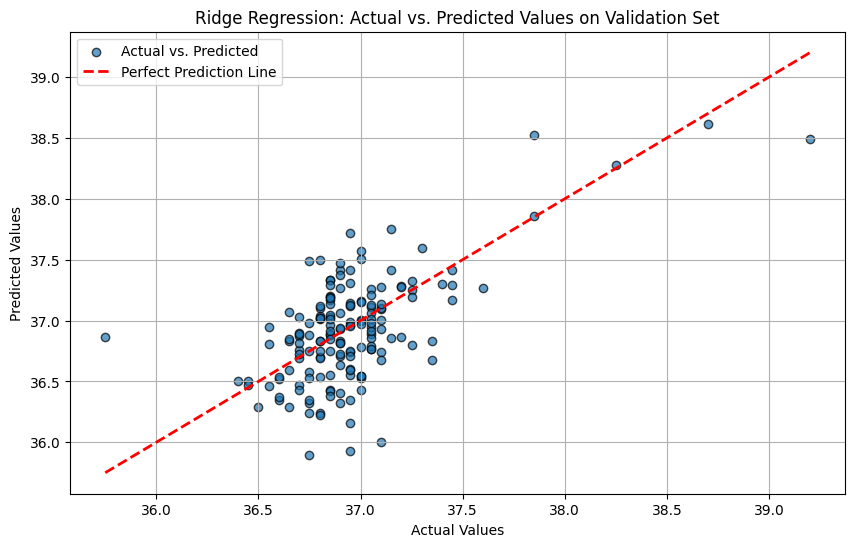

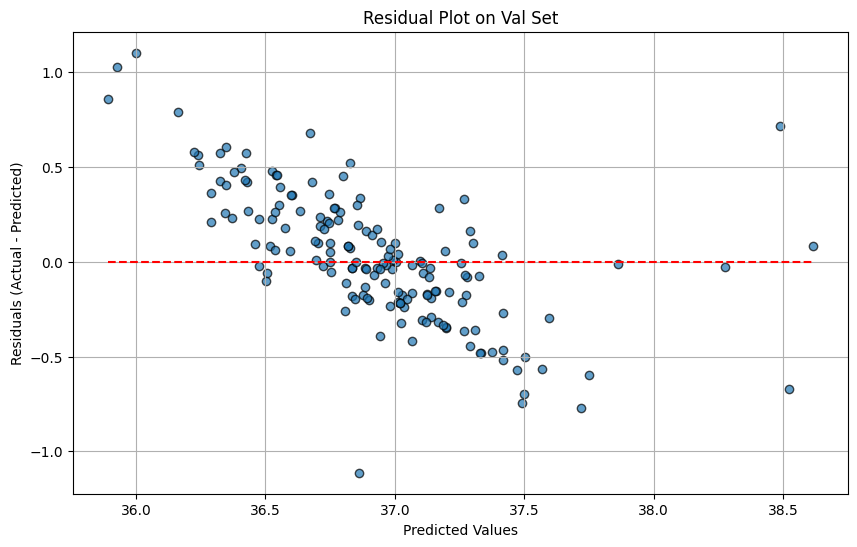

In [26]:
y_pred_test = final_ridge_model_weighted.predict(X_val)

mse_test = mean_squared_error(y_val, y_pred_test)
r2_test = r2_score(y_val, y_pred_test)

print(f"Mean Squared Error (MSE): {mse_test:.4f}")
# print(f"R-squared (R²): {r2_test:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_test, alpha=0.7, edgecolors='k', label='Actual vs. Predicted')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs. Predicted Values on Validation Set")
plt.legend()
plt.grid(True)
plt.show()

residuals = y_val - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, edgecolors='k')
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot on Val Set")
plt.grid(True)
plt.show()

In [27]:
from sklearn.linear_model import Ridge, RidgeCV

X_train = train_scaled[reduced_cols]
y_train = train_scaled[target_col]

# alphas_to_try = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_cv_model_weighted = RidgeCV(cv=5)

ridge_cv_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use)

best_alpha_weighted = ridge_cv_model_weighted.alpha_
# print(f"Best alpha found by RidgeCV: {best_alpha_weighted:.4f}")

final_ridge_model_weighted = Ridge(alpha=best_alpha_weighted, random_state=42)
final_ridge_model_weighted.fit(X_train, y_train, sample_weight=weights_to_use)

intercept = final_ridge_model_weighted.intercept_
# print(f"Intercept: {intercept:.4f}")

coefficients = final_ridge_model_weighted.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print("\nCoefficients :")
print(coef_df.to_string())



Coefficients :
        Feature  Coefficient
0     Max1R13_1    -0.031648
1     Max1L13_1     0.181295
2   aveAllR13_1     0.169535
3   aveAllL13_1    -0.217650
4       T_FHCC1    -0.069342
5       T_FHRC1     0.067581
6       T_FHLC1    -0.050004
7       T_FHTC1     0.008734
8     T_FH_Max1     0.370652
9    T_FHC_Max1    -0.332510
10       T_Max1     0.164336
11        T_OR1     0.226327
12        T_atm    -0.026150
13     Humidity     0.086801
14     Distance     0.007974
15    T_offset1     0.099690


## performance on test set

In [28]:
test_scaled = test_scaled.fillna(column_means)
X_test = test_scaled[reduced_cols]
y_test = test_scaled[target_col]

### OLS

MSE: 0.0571
R-squared: 0.5255




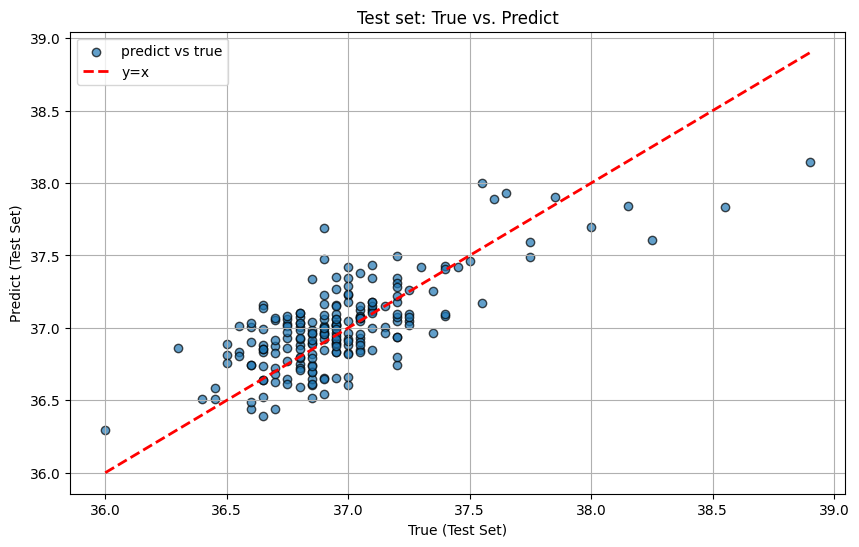

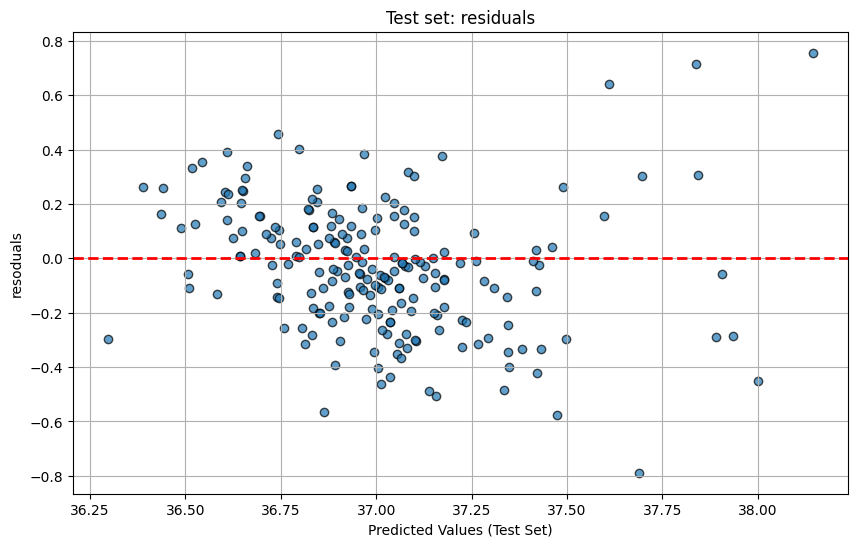

In [29]:
X_test_const = sm.add_constant(X_test, has_constant='add')

y_pred_test = ols_results.predict(X_test_const)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE: {mse_test:.4f}")
print(f"R-squared: {r2_test:.4f}")
print("\n")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k', label='predict vs true')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
plt.xlabel("True (Test Set)")
plt.ylabel("Predict (Test Set)")
plt.title("Test set: True vs. Predict")
plt.legend()
plt.grid(True)
plt.show()

residuals_test = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Values (Test Set)")
plt.ylabel("resoduals")
plt.title("Test set: residuals")
plt.grid(True)
plt.show()



In [30]:
actual_fever_mask = (y_test > 37.5)

y_test_with_actual_fever = y_test[actual_fever_mask]

if not y_test_with_actual_fever.empty:

    y_pred_for_those_with_actual_fever = y_pred_test[actual_fever_mask]

    # Among those with actual fever, count how many were predicted to have fever
    predicted_fever_among_actual_fever_count = np.sum(y_pred_for_those_with_actual_fever > 37.5)

    fever_detection_rate = predicted_fever_among_actual_fever_count / len(y_test_with_actual_fever)

    print(f"Number of samples with actual fever (y_test > 37.5): {len(y_test_with_actual_fever)}")
    print(f"Number of these samples predicted as fever (y_pred_test > 37.5): {predicted_fever_among_actual_fever_count}")
    print(f"Rate of correctly predicting fever for those with fever: {fever_detection_rate:.4f}")
else:
    print("No samples with actual fever (y_test > 37.5) in the test set.")
    
mse_test = mean_squared_error(y_test_with_actual_fever, y_pred_for_those_with_actual_fever)
print(f"Mean Squared Error (MSE) for fever: {mse_test:.4f}")


Number of samples with actual fever (y_test > 37.5): 12
Number of these samples predicted as fever (y_pred_test > 37.5): 10
Rate of correctly predicting fever for those with fever: 0.8333
Mean Squared Error (MSE) for fever: 0.1902


### WLS

MSE: 0.1405




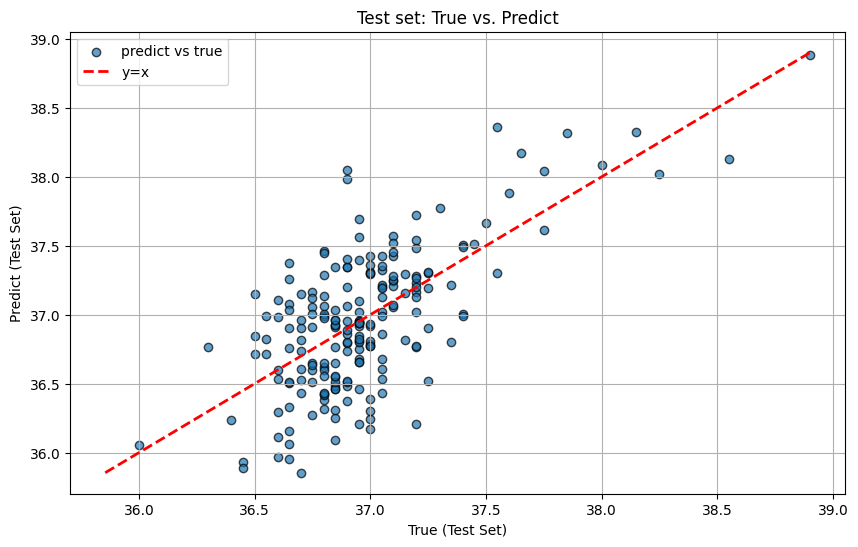

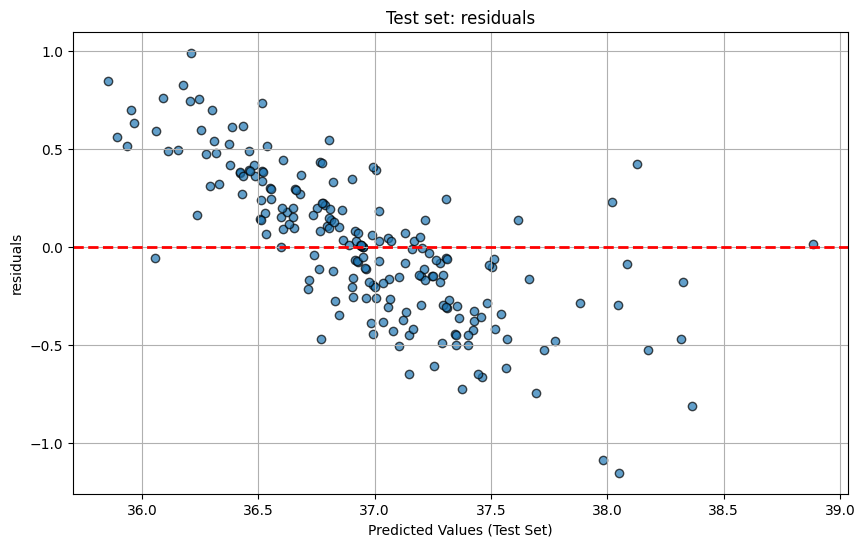

In [31]:
y_pred_test = wls_results.predict(X_test_const)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE: {mse_test:.4f}")
# print(f"R-squared: {r2_test:.4f}")
print("\n")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k', label='predict vs true')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
plt.xlabel("True (Test Set)")
plt.ylabel("Predict (Test Set)")
plt.title("Test set: True vs. Predict")
plt.legend()
plt.grid(True)
plt.show()

residuals_test = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Values (Test Set)")
plt.ylabel("residuals")
plt.title("Test set: residuals")
plt.grid(True)
plt.show()



In [32]:
actual_fever_mask = (y_test > 37.5)

y_test_with_actual_fever = y_test[actual_fever_mask]

if not y_test_with_actual_fever.empty:

    y_pred_for_those_with_actual_fever = y_pred_test[actual_fever_mask]

    # Among those with actual fever, count how many were predicted to have fever
    predicted_fever_among_actual_fever_count = np.sum(y_pred_for_those_with_actual_fever > 37.5)

    fever_detection_rate = predicted_fever_among_actual_fever_count / len(y_test_with_actual_fever)

    print(f"Number of samples with actual fever (y_test > 37.5): {len(y_test_with_actual_fever)}")
    print(f"Number of these samples predicted as fever (y_pred_test > 37.5): {predicted_fever_among_actual_fever_count}")
    print(f"Rate of correctly predicting fever for those with fever: {fever_detection_rate:.4f}")
else:
    print("No samples with actual fever (y_test > 37.5) in the test set.")
    
mse_test = mean_squared_error(y_test_with_actual_fever, y_pred_for_those_with_actual_fever)
print(f"Mean Squared Error (MSE) for fever: {mse_test:.4f}")


Number of samples with actual fever (y_test > 37.5): 12
Number of these samples predicted as fever (y_pred_test > 37.5): 11
Rate of correctly predicting fever for those with fever: 0.9167
Mean Squared Error (MSE) for fever: 0.1392


### Weighted Lasso

Mean Squared Error (MSE): 0.1083


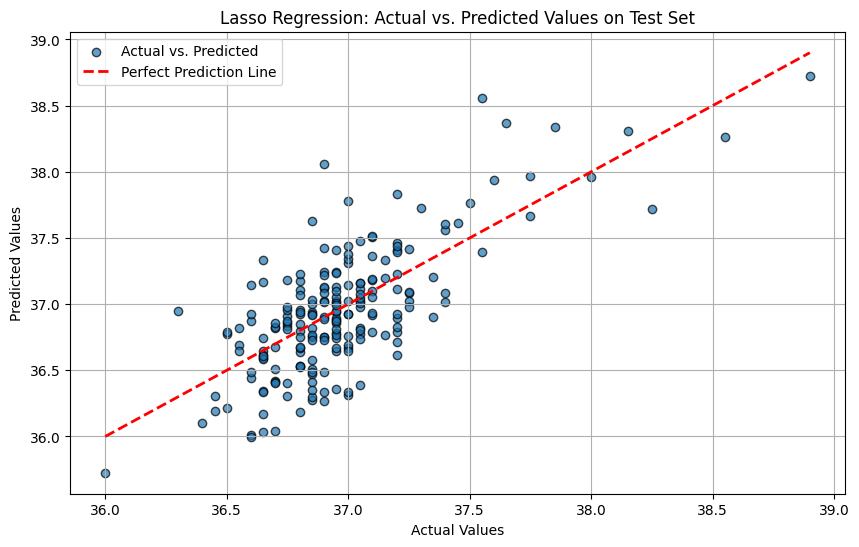

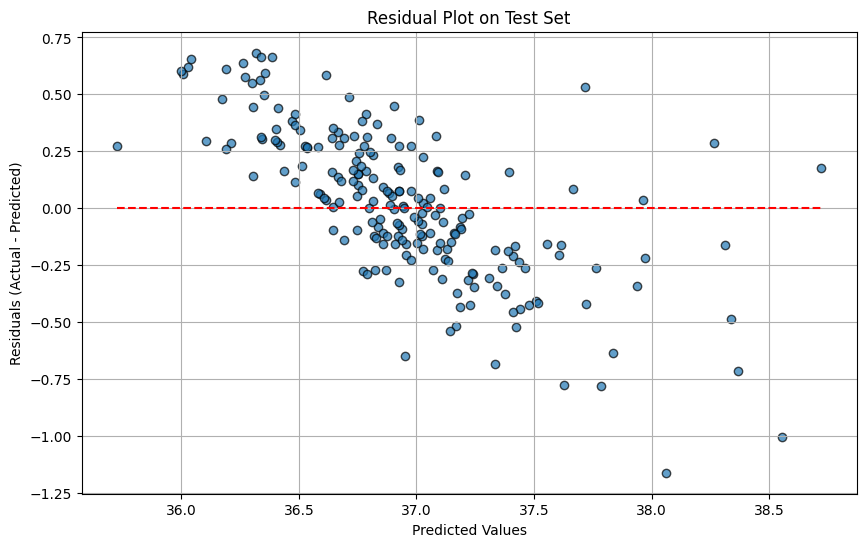

In [33]:
y_pred_test = final_lasso_model_weighted.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Mean Squared Error (MSE): {mse_test:.4f}")
# print(f"R-squared (R²): {r2_test:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression: Actual vs. Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()

residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, edgecolors='k')
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot on Test Set")
plt.grid(True)
plt.show()

In [34]:
actual_fever_mask = (y_test > 37.5)

y_test_with_actual_fever = y_test[actual_fever_mask]

if not y_test_with_actual_fever.empty:

    y_pred_for_those_with_actual_fever = y_pred_test[actual_fever_mask]

    # Among those with actual fever, count how many were predicted to have fever
    predicted_fever_among_actual_fever_count = np.sum(y_pred_for_those_with_actual_fever > 37.5)

    fever_detection_rate = predicted_fever_among_actual_fever_count / len(y_test_with_actual_fever)

    print(f"Number of samples with actual fever (y_test > 37.5): {len(y_test_with_actual_fever)}")
    print(f"Number of these samples predicted as fever (y_pred_test > 37.5): {predicted_fever_among_actual_fever_count}")
    print(f"Rate of correctly predicting fever for those with fever: {fever_detection_rate:.4f}")
else:
    print("No samples with actual fever (y_test > 37.5) in the test set.")
    
mse_test = mean_squared_error(y_test_with_actual_fever, y_pred_for_those_with_actual_fever)
print(f"Mean Squared Error (MSE) for fever: {mse_test:.4f}")


Number of samples with actual fever (y_test > 37.5): 12
Number of these samples predicted as fever (y_pred_test > 37.5): 11
Rate of correctly predicting fever for those with fever: 0.9167
Mean Squared Error (MSE) for fever: 0.1986


### Weighted Ridge

Mean Squared Error (MSE): 0.1394


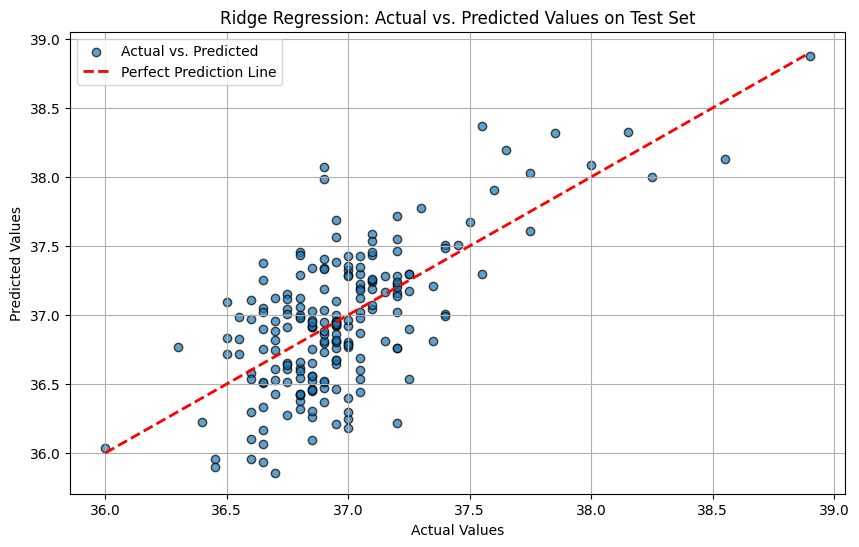

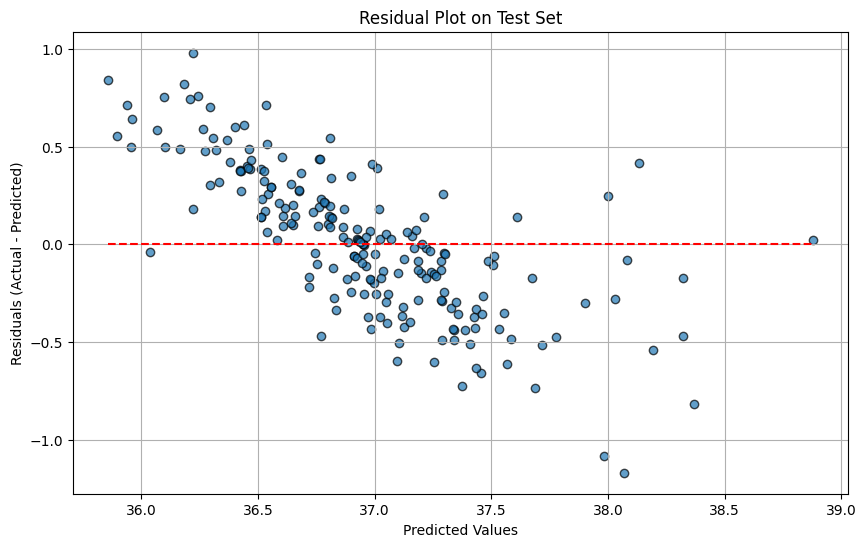

In [35]:
y_pred_test = final_ridge_model_weighted.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Mean Squared Error (MSE): {mse_test:.4f}")
# print(f"R-squared (R²): {r2_test:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs. Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()

residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, edgecolors='k')
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot on Test Set")
plt.grid(True)
plt.show()

In [36]:
actual_fever_mask = (y_test > 37.5)

y_test_with_actual_fever = y_test[actual_fever_mask]

if not y_test_with_actual_fever.empty:

    y_pred_for_those_with_actual_fever = y_pred_test[actual_fever_mask]

    # Among those with actual fever, count how many were predicted to have fever
    predicted_fever_among_actual_fever_count = np.sum(y_pred_for_those_with_actual_fever > 37.5)

    fever_detection_rate = predicted_fever_among_actual_fever_count / len(y_test_with_actual_fever)

    print(f"Number of samples with actual fever (y_test > 37.5): {len(y_test_with_actual_fever)}")
    print(f"Number of these samples predicted as fever (y_pred_test > 37.5): {predicted_fever_among_actual_fever_count}")
    print(f"Rate of correctly predicting fever for those with fever: {fever_detection_rate:.4f}")
else:
    print("No samples with actual fever (y_test > 37.5) in the test set.")
    
mse_test = mean_squared_error(y_test_with_actual_fever, y_pred_for_those_with_actual_fever)
print(f"Mean Squared Error (MSE) for fever: {mse_test:.4f}")


Number of samples with actual fever (y_test > 37.5): 12
Number of these samples predicted as fever (y_pred_test > 37.5): 11
Rate of correctly predicting fever for those with fever: 0.9167
Mean Squared Error (MSE) for fever: 0.1429


### Logit

Abnormal Tref in training set:
None

Abnormal Tref in testing set:
None

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       192
           1       0.88      0.58      0.70        12

    accuracy                           0.97       204
   macro avg       0.92      0.79      0.84       204
weighted avg       0.97      0.97      0.97       204

AUC = 0.984


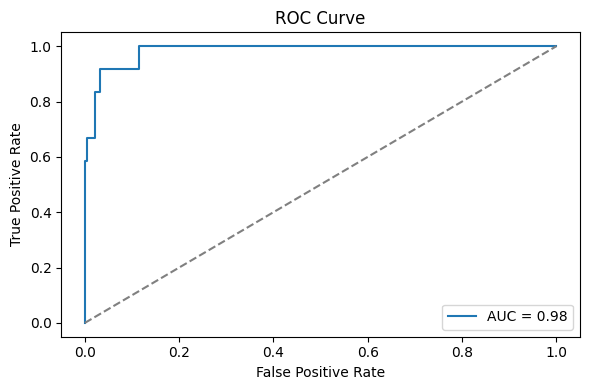


Probabilistic Regression Metrics:
Mean Squared Error (MSE): 0.0207
Mean Absolute Error (MAE): 0.0456

Performance using 37.5°C Threshold:
Sensitivity (Recall for fever): 0.58
Specificity (Recall for non-fever): 0.99
Accuracy: 0.97

Confusion Matrix:
[[191   1]
 [  5   7]]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Gender', 'Age', 'Ethnicity']
reduced_cols = ['T_Max1', 'aveAllL13_1', 'canthi4Max1', 'aveAllR13_1', 'RCC1', 'T_FHRC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_OR_Max1', 'T_FHBC1', 'T_FHLC1', 'LCC1']

X_cat_train = pd.get_dummies(train_df[cat_cols], drop_first=True)
X_cat_test = pd.get_dummies(test_df[cat_cols], drop_first=True)

X_train_logit = pd.concat([train_scaled[reduced_cols], X_cat_train], axis=1)
X_test_logit = pd.concat([test_scaled[reduced_cols], X_cat_test], axis=1)

y_train_logit = (train_df[target_col] > 37.5).astype(int)
y_test_logit = (test_df[target_col] > 37.5).astype(int)

# Check for abnormal values (Tref > 40°C)
abnormal_thresh = 40.0
abnormal_train = train_df[train_df[target_col] > abnormal_thresh]
abnormal_test = test_df[test_df[target_col] > abnormal_thresh]

print("Abnormal Tref in training set:")
print("None" if abnormal_train.empty else abnormal_train[[target_col]])

print("\nAbnormal Tref in testing set:")
print("None" if abnormal_test.empty else abnormal_test[[target_col]])

# Fit logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_logit, y_train_logit)

y_pred = logreg.predict(X_test_logit)
y_prob = logreg.predict_proba(X_test_logit)[:, 1]

# General evaluation
print("\nClassification Report:")
print(classification_report(y_test_logit, y_pred))

auc = roc_auc_score(y_test_logit, y_prob)
print(f"AUC = {auc:.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_logit, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Performance on fever classification at 37.5°C
cm = confusion_matrix(y_test_logit, y_pred)
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float("nan")
    accuracy = (tp + tn) / cm.sum()
else:
    sensitivity = specificity = accuracy = float("nan")


# MSE and MAE using predicted probabilities
mse = mean_squared_error(y_test_logit, y_prob)
mae = mean_absolute_error(y_test_logit, y_prob)

print(f"\nProbabilistic Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

print("\nPerformance using 37.5°C Threshold:")
print(f"Sensitivity (Recall for fever): {sensitivity:.2f}")
print(f"Specificity (Recall for non-fever): {specificity:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(cm)
